<h2>Including all required additional tools</h2>

In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.data import *
from fastai.callbacks import *
import random

class MixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            new_input = (last_input * lambd.view(lambd.size(0),1,1,1) + x1 * (1-lambd).view(lambd.size(0),1,1,1))
        if self.stack_y:
            new_target = torch.cat([last_target[:,None].float(), y1[:,None].float(), lambd[:,None].float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()
        

class MixUpLoss(nn.Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.size()) == 2:
            loss1, loss2 = self.crit(output,target[:,0].long()), self.crit(output,target[:,1].long())
            d = (loss1 * target[:,2] + loss2 * (1-target[:,2])).mean()
        else:  d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum':            return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

def mixup(learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True) -> Learner:
    "Add mixup https://arxiv.org/abs/1710.09412 to `learn`."
    learn.callback_fns.append(partial(MixUpCallback, alpha=alpha, stack_x=stack_x, stack_y=stack_y))
    return learn

Learner.mixup = mixup

In [2]:
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

In [3]:
def lwlrap(y_pred,y_true):
    score, weight = calculate_per_class_lwlrap(y_true.cpu().numpy(), y_pred.cpu().numpy())
    lwlrap = (score * weight).sum()
    return torch.from_numpy(np.array(lwlrap))

<h2>Importing dependencies and loading files</h2>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.callbacks import *
import random

In [5]:
DATA = Path('freesound_audio_tagging')
PREPROCESSED = Path('fat2019')
WORK = Path('work')

CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_TRN_NOISY_BEST50S = PREPROCESSED/'trn_noisy_best50s.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'

MELS_TRN_CURATED = PREPROCESSED/'mels_train_curated.pkl'
MELS_TRN_NOISY = PREPROCESSED/'mels_train_noisy.pkl'
MELS_TRN_NOISY_BEST50S = PREPROCESSED/'mels_trn_noisy_best50s.pkl'
MELS_TEST = PREPROCESSED/'mels_test.pkl'

trn_curated_df = pd.read_csv(CSV_TRN_CURATED)
trn_noisy_df = pd.read_csv(CSV_TRN_NOISY)
trn_noisy50s_df = pd.read_csv(CSV_TRN_NOISY_BEST50S)
test_df = pd.read_csv(CSV_SUBMISSION)

trn_df = pd.concat([trn_curated_df, trn_noisy50s_df], sort=True, ignore_index=True)

In [6]:
SEED = 2000
BS = 128
SIZE = 128

In [7]:
X_train_curated = pickle.load(open(MELS_TRN_CURATED, 'rb')) + pickle.load(open(MELS_TRN_NOISY_BEST50S, 'rb'))

In [8]:
CUR_X_FILES, CUR_X = list(trn_df.fname.values), X_train_curated

def open_fat2019_image(fn, convert_mode, after_open)->Image:
    # open
    idx = CUR_X_FILES.index(fn.split('/')[-1])
    x = PIL.Image.fromarray(CUR_X[idx])
    # crop 1sec
    time_dim, base_dim = x.size
    crop_x = random.randint(0, time_dim - base_dim)
    x = x.crop([crop_x, 0, crop_x+base_dim, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_fat2019_image

In [10]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)

src = (ImageList.from_df(trn_df, WORK, folder=" ")
       .split_by_rand_pct(0.2, seed=SEED)
       .label_from_df(label_delim=',')
      )

data = (src.transform(tfms, size=SIZE)
        .databunch(bs=BS)
        .normalize(imagenet_stats)
       )

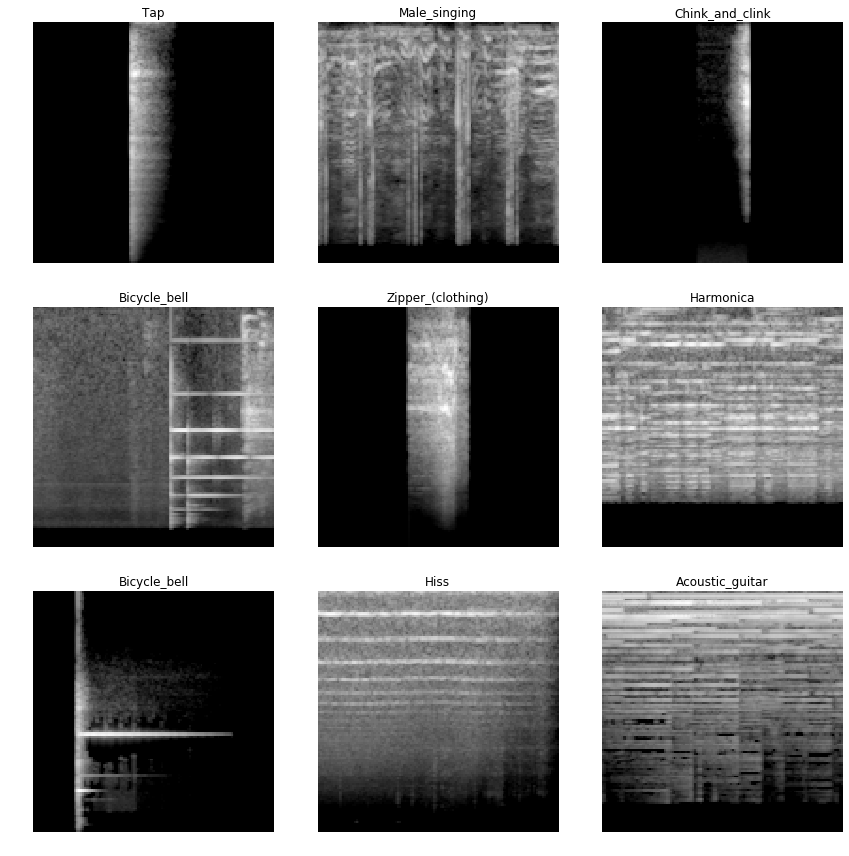

In [11]:
data.show_batch(3)

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x
    
class Classifier(nn.Module):
    def __init__(self, num_classes=1000): # <======== modificaition to comply fast.ai
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # <======== modificaition to comply fast.ai
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        #x = torch.mean(x, dim=3)   # <======== modificaition to comply fast.ai
        #x, _ = torch.max(x, dim=2) # <======== modificaition to comply fast.ai
        x = self.avgpool(x)         # <======== modificaition to comply fast.ai
        x = self.fc(x)
        return x

In [25]:
def borrowed_model(pretrained=False, **kwargs):
    return Classifier(**kwargs)

learn = cnn_learner(data, borrowed_model, pretrained=False, metrics=[lwlrap]).mixup(stack_y=False)
learn.unfreeze()

In [26]:
learn.load("baseline_final_model")

Learner(data=ImageDataBunch;

Train: LabelList (7176 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Bark,Raindrop,Finger_snapping,Run,Whispering
Path: work;

Valid: LabelList (1794 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Traffic_noise_and_roadway_noise,Zipper_(clothing),Cupboard_open_or_close,Printer,Bark
Path: work;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momen

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06


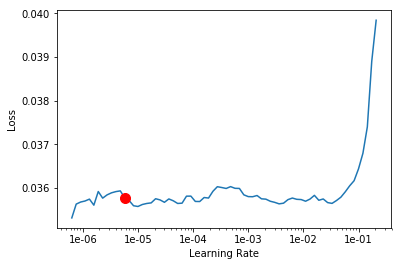

In [27]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [28]:
cb1 = SaveModelCallback(learn, every='improvement', monitor='lwlrap', name='baseline_final_model')

In [ ]:
learn.fit_one_cycle(86, 4e-3, callbacks=cb1)

epoch,train_loss,valid_loss,lwlrap,time
0,0.035277,0.033863,0.664356,00:24
1,0.035208,0.033972,0.664064,00:24
2,0.035408,0.034193,0.658379,00:24
3,0.035340,0.034096,0.662101,00:24
4,0.035052,0.034404,0.664099,00:24
5,0.035222,0.041692,0.663218,00:24
6,0.035275,0.033859,0.664934,00:24


Better model found at epoch 0 with lwlrap value: 0.6643562495728297.
Better model found at epoch 6 with lwlrap value: 0.6649342765528661.


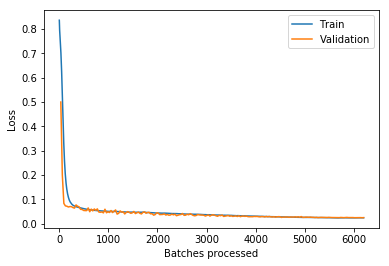

In [17]:
learn.recorder.plot_losses()

In [18]:
learn.load("baseline_final_model")

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Learner(data=ImageDataBunch;

Train: LabelList (3976 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Raindrop,Run,Finger_snapping,Whispering,Acoustic_guitar;Strum
Path: work;

Valid: LabelList (994 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
Run,Walk_and_footsteps,Waves_and_surf,Knock,Marimba_and_xylophone
Path: work;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): ConvBlock(
        (conv1): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=

In [19]:
learn.export()